## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, compute the camera calibration using chessboard images

In [20]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
#%matplotlib qt

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny* nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # plt.imshow(gray)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, corners, gray.shape[::-1], None, None)
        #undist = cv2.undistort(img, mtx, dist, None, mtx)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #undistorted_images.append(undist)
        
print(np.shape(objpoints))
print(np.shape(imgpoints))

################ define a function to undistort an image
def cal_undistort(img, nx, ny, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

(17, 54, 3)
(17, 54, 1, 2)


./camera_cal/calibration1.jpg


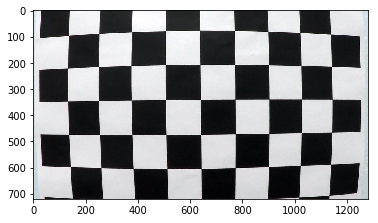

In [21]:
## testing the images 
idx = 7;
test_fname = images[idx]
print(test_fname)
test_img = cv2.imread(test_fname)
plt.imshow(test_img)
plt.show()

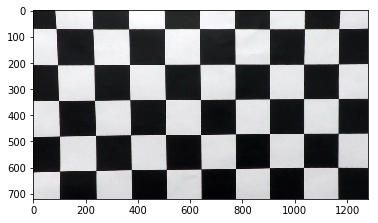

In [22]:
######## print out the undistorted images
undistorted_image = cal_undistort(test_img, nx, ny, objpoints, imgpoints)
plt.imshow(undistorted_image)
plt.show()

## Apply undistortion to new images (test images)

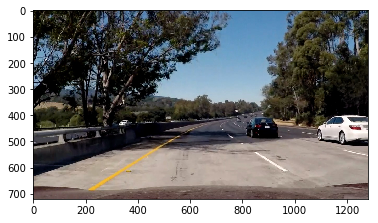

In [23]:
raw_lane_images = glob.glob('./test_images/test*.jpg')
img = cv2.imread(raw_lane_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

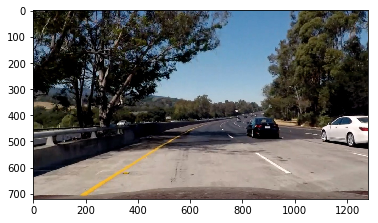

In [24]:
undistorted_image = cal_undistort(img, nx, ny, objpoints, imgpoints)
plt.imshow(undistorted_image)
plt.show()

### Using color transform and sobel filter to create a thresholded binary image

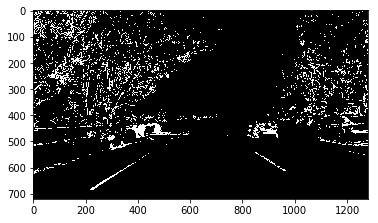

In [25]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

    
hls_binary = hls_select(img, thresh = (200, 255))
plt.imshow(hls_binary, cmap='gray')
plt.show()

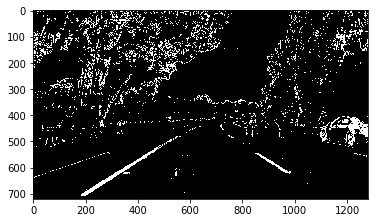

In [26]:
def getsobel(img, orient = 'x', sobel_kernel = 3):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return scaled_sobel

def threshold_img(img, sobel_kernel = 3, color_thresh = (120, 255), light_thresh = (50, 255), sobel_thresh = (20, 255), select_mask = (1,1,1)):
    # first convert the image from RGB to HLS
    s_binary = hls_select(img, color_thresh)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    
    # only get the "light" areas
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > light_thresh[0]) & (l_channel <= light_thresh[1])] = 1
    
    # apply gradient threshold
    scaled_sobelx = getsobel(img, 'x', sobel_kernel)
    scaled_sobely = getsobel(img, 'y', sobel_kernel)
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sobel_thresh[0]) & (scaled_sobelx <= sobel_thresh[1])] = 1
    
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sobel_thresh[0]) & (scaled_sobely <= sobel_thresh[1])] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    if select_mask[0] == 1:
        combined_binary |= (s_binary == 1)
        #plt.imshow(combined_binary, cmap = 'gray')
        #plt.show()
    if select_mask[1] == 1:
        combined_binary |= (sxbinary == 1)
        #plt.imshow(combined_binary, cmap = 'gray')
        #plt.show()
    if select_mask[2] == 1:
        combined_binary |= (sybinary == 1)
        #plt.imshow(combined_binary, cmap = 'gray')
        #plt.show()
        
    combined_binary &= (l_binary == 1)
    return combined_binary

threshed_img = threshold_img(undistorted_image, select_mask = (1,1,0))
plt.imshow(threshed_img, cmap = 'gray')
plt.show()

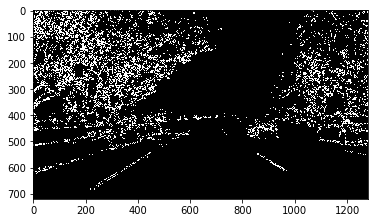

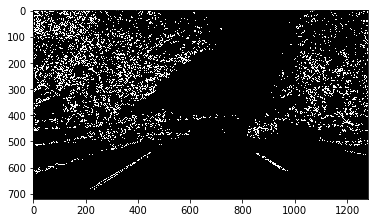

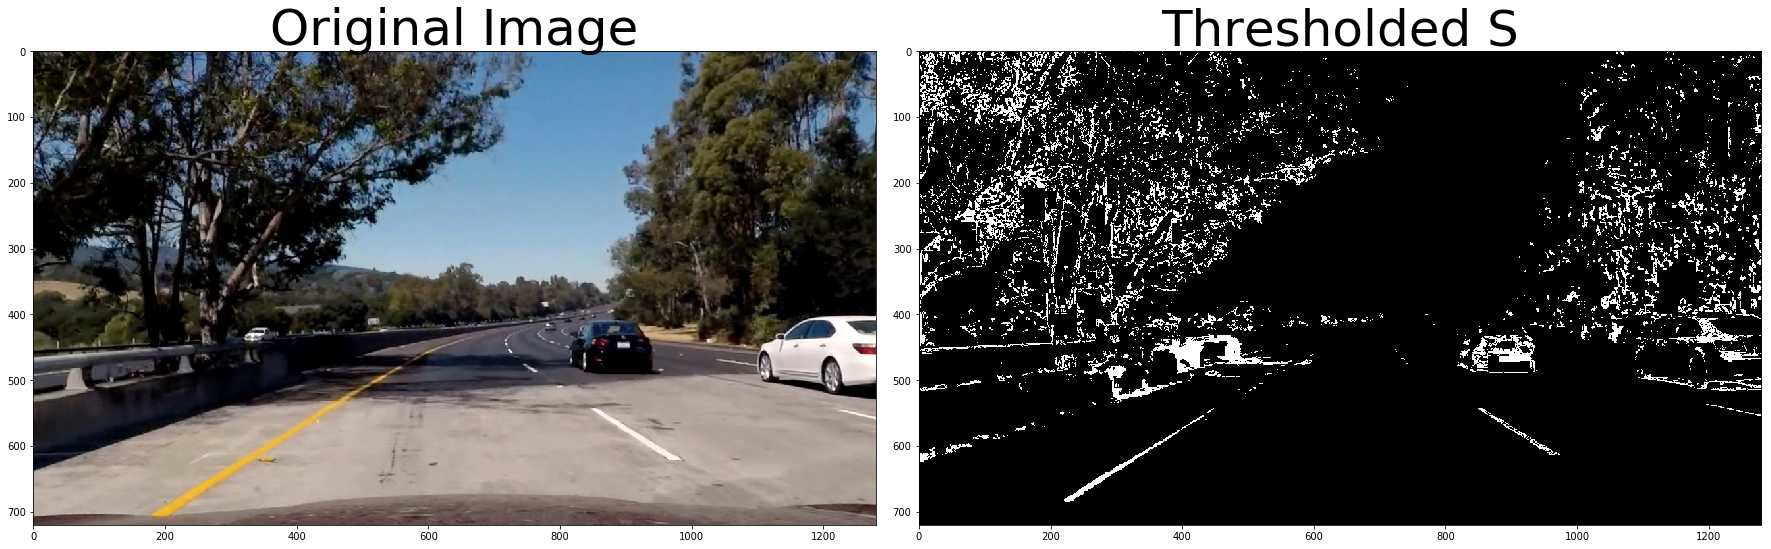

In [27]:
## using magnitude
mag_thresh = (10, 200)
sobel_kernel = 3
sobelx = cv2.Sobel(hls_binary, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
sobely = cv2.Sobel(hls_binary, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
mag = np.sqrt(sobelx**2 + sobely**2)
factor = 255/np.max(mag)
scaled = (factor*mag).astype(np.uint8)
binary_output = np.zeros_like(scaled)
binary_output[(scaled <= mag_thresh[1]) & (scaled >= mag_thresh[0])] = 1
plt.imshow(binary_output, cmap = 'gray')
plt.show()

# using angle
thresh = (0.7, 1.3)
sobelx = cv2.Sobel(hls_binary, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
sobely = cv2.Sobel(hls_binary, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
binary_output =  np.zeros_like(absgraddir)
binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
plt.imshow(binary_output, cmap = 'gray')
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Apply perspective transformation


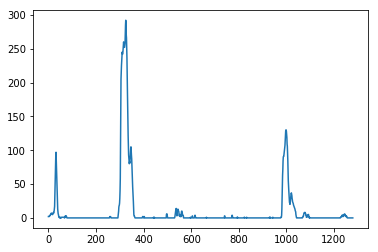

In [28]:
def hist(img):    
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis = 0)
    return histogram

histogram = hist(top_down)

plt.plot(histogram)
plt.show()

(720, 1280)


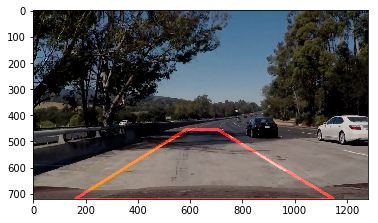

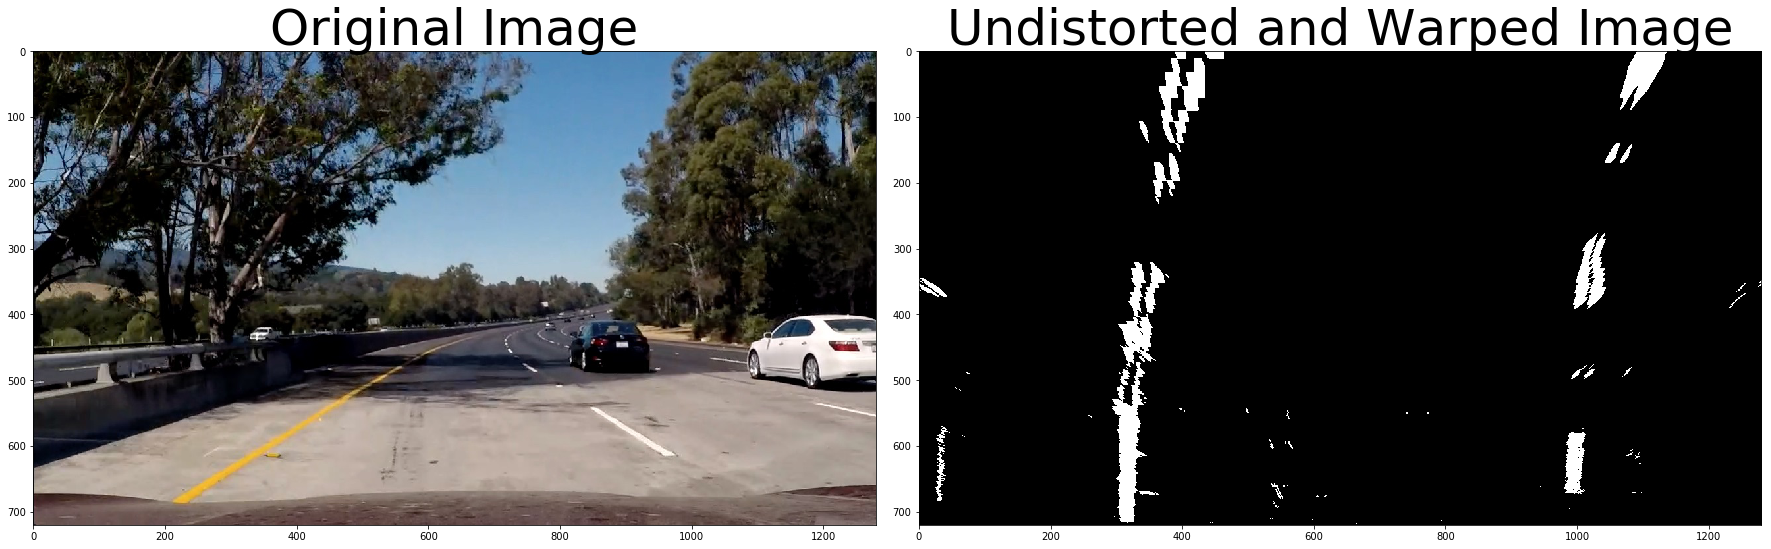

In [29]:
img_size = np.shape(threshed_img)
print(img_size)
# set perspective transformation parameters
offset = 150
left_bottom_x = 160
right_bottom_x = 1150
left_top_x = 585
right_top_x = 705
src = np.float32([[left_top_x, 455], [right_top_x, 455], [right_bottom_x, 720], [left_bottom_x, 720]])
dst = np.float32([[left_bottom_x + offset, 0], [right_bottom_x-offset, 0], [right_bottom_x-offset, img_size[0]], [left_bottom_x + offset, img_size[0]]])

def perspective_transform(img, src, dst, birdeye = True):
    img_size = (img.shape[1], img.shape[0])
    if birdeye:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M

def plot_region(img, src):
    line_image = np.copy(img)*0
    for i in range(4):
        cv2.line(line_image, (src[i][0], src[i][1]), (src[(i+1)%4][0], src[(i+1)%4][1]), (255,0,0), 10)
    
    #line_image = np.dstack(line_image, line_image, line_image)
    lined_img = cv2.addWeighted(img, 0.8, line_image, 1, 0) 
    return lined_img

lined_img = plot_region(img, src)
plt.imshow(lined_img)
plt.show()
top_down, M = perspective_transform(threshed_img, src, dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap = 'gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

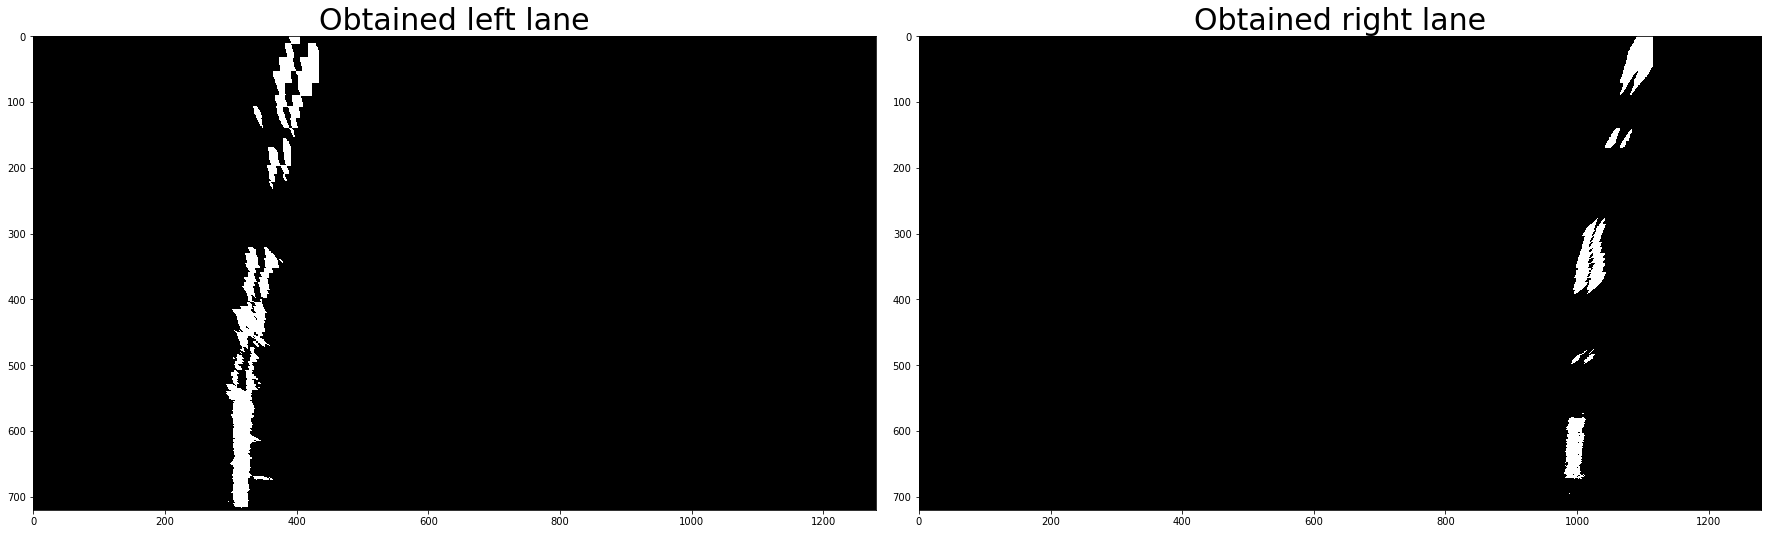

In [30]:
def find_lane_pixels(img, truncate = (0, 1280), nwindows=9, margin = 50, minpix = 10):
    histogram = hist(img)
    out_img = np.dstack((img, img, img))
    midpoint = np.int(histogram.shape[0]//2)
    
    leftx_base = np.argmax(histogram[truncate[0]: midpoint])
    rightx_base = np.argmax(histogram[midpoint:truncate[1]]) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

leftx, lefty, rightx, righty, out_img = find_lane_pixels(top_down)

def get_lane(bin_img, px, py):
    lane_img = np.zeros_like(bin_img)
    for i in range(len(px)):
        lane_img[py[i]][px[i]] = 1
    return lane_img

left_lane = get_lane(top_down, leftx, lefty)
right_lane = get_lane(top_down, rightx, righty)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(left_lane, cmap = 'gray')
ax1.set_title('Obtained left lane', fontsize=30)
ax2.imshow(right_lane, cmap = 'gray')
ax2.set_title('Obtained right lane', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

(720, 1280, 3)


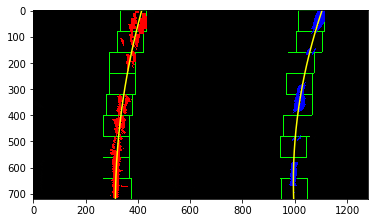

In [31]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img
out_img = fit_polynomial(top_down)
print(np.shape(out_img))
plt.imshow(out_img)
plt.show()

In [32]:
# Define a class to receive the characteristics of each line detection
from collections import deque
class Line():
    def __init__(self, n = 5):
        # was the line detected in the last iteration?
        self.detected = False  
        # n fits
        self.n = n
        
        # x values of the last n fits of the line
        self.recent_xfitted = deque([],maxlen=n)
        # coefficients of last n fitted polynomials
        self.recent_fitted_coef = deque([], maxlen = n)
        #average x values of the fitted line over the last n iterations
        self.avgx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
         
        #radius of curvature of the line in some units
        self.curvature = None 
        self.curvature_meters = None
        
        #distance in meters of vehicle center from the line
        self.lane_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        #polynomial coefficients for the most recent fit
        self.current_coef = [np.array([False])] 
        self.current_coef_m = [np.array([False])] 
        
        # ploty = np.linspace(0, 719, num=720)
        self.yvals = np.linspace(0, 719, num=720)  # always the same y-range as imag
        self.fitted_xvals = [np.array([False])]
        
        self.ym_per_pix = 30/720  # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
    def set_fit_xvals(self):
        yvals = self.yvals
        self.fitted_xvals = self.current_coef[0]*yvals**2 + self.current_coef[1]*yvals + self.current_coef[2]
        
    def add_data(self):
        self.recent_xfitted.appendleft(self.fitted_xvals)
        self.recent_fitted_coef.appendleft(self.current_coef)        
        
    def set_coef(self):
        self.current_coef = np.polyfit(self.ally, self.allx, 2)
        self.current_coef_m = np.polyfit(self.ally*self.ym_per_pix, self.allx*self.xm_per_pix, 2)

    def set_avgx(self):
        self.avgx = np.mean(np.array(self.recent_xfitted))

    def set_curvature(self):
        y_eval = max(self.yvals) 
        y_eval_m = y_eval*self.ym_per_pix
        # calculate using current value
        self.curvature = ((1 + (2*self.current_coef[0]*y_eval + self.current_coef[1])**2)**1.5)/np.abs(2*self.current_coef[0])
        # calculate using avgerage value
        self.curvature_meters = ((1 + (2*self.current_coef_m[0]*y_eval_m + self.current_coef_m[1])**2)**1.5)/np.abs(2*self.current_coef_m[0])
    
    def set_allxally(self, lane_img):
        self.ally, self.allx = (lane_img > 0).nonzero()
    
    def set_lane_pos(self):
        yMax = 720
        self.lane_pos = self.current_coef[0]*yMax**2 + self.current_coef[1]*yMax + self.current_coef[2]
        # self.lane_pos *= self.ym_per_pix
        
    def set_all(self, lane):
        # fill the information retrieved from lane img to the pixel locations
        self.set_allxally(lane)
        # calculate the polynomials
        self.set_coef()
        # get the predicted values
        self.set_fit_xvals()
        # get curvature
        self.set_curvature()
        # set position of the lane
        self.set_lane_pos()

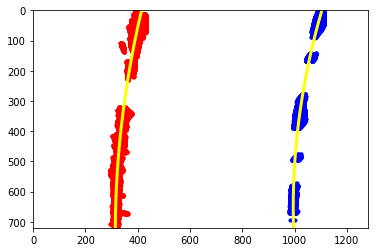

Difference:  0.0796543182596
Left Lane Curvature:  894.117400763
Right Lane Curvature:  640.00053517


In [35]:
left = Line()
right = Line()

left.set_all(left_lane)
right.set_all(right_lane)

#def pixel2meter(curvature):   
yvals = left.yvals
left_fitx = left.fitted_xvals

plt.plot(left.allx, left.ally, '.', color='red')
plt.plot(left_fitx, yvals, color='yellow', linewidth=3)

right_fitx = right.fitted_xvals
plt.plot(right.allx, right.ally, '.', color='blue')
plt.plot(right_fitx, yvals, color='yellow', linewidth=3)

plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.gca().invert_yaxis()
plt.show()

def get_bias(left, right):
    xm_per_pix = (3.7/700)
    vehiclecenter = 640  # this is calculated by image[1]/2* xm_per_pix
    left_pos = left.lane_pos # in metric pixel
    right_pos = right.lane_pos # in metric pixel, ranging in [0, 1280]
    mid_pos = (left_pos + right_pos)/2
    diff = mid_pos - vehiclecenter
    diff *= xm_per_pix
    return diff
    
# thus, the vehicle is diff-meters left of center
diff = get_bias(left, right)
left_lane_curvature = left.curvature_meters
right_lane_curvature = right.curvature_meters
print("Difference: ", diff)
print("Left Lane Curvature: ", left_lane_curvature)
print("Right Lane Curvature: ", right_lane_curvature)

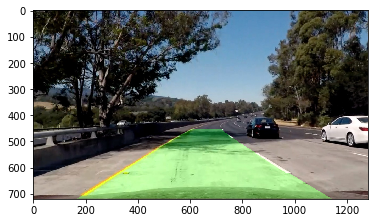

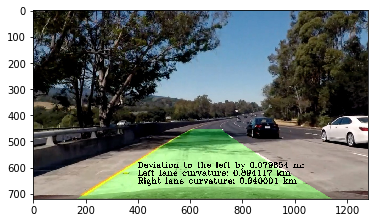

In [36]:
# Create an image to draw the lines on
def draw_img(top_down, undistorted_image, left_fitx, right_fitx):
    yvals = np.linspace(0, 719, num=720) 
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp,_ = perspective_transform(color_warp, src, dst, birdeye = False)
    # newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    return result


result = draw_img(top_down, undistorted_image, left_fitx, right_fitx)
plt.imshow(result)
plt.show()

def add_info(result, left, right):
    diff = get_bias(left, right)
    left_lane_curvature = left.curvature_meters
    right_lane_curvature = right.curvature_meters
    
    diff_text_location = (400, 600)
    font = cv2.FONT_HERSHEY_COMPLEX
    if diff>0:
        cv2.putText(result, 'Deviation to the left by {0:6f} m: '.format(diff), (diff_text_location), font, 1, (0,0,0), 2)
    else:
        cv2.putText(result, 'Deviation to the right by {0:6f} m: '.format(-diff), diff_text_location, font, 1, (0,0,0), 2)
    
    cv2.putText(result, 'Left lane curvature: {0:6f} km'.format(left_lane_curvature/1000), (400, 630), font, 1, (0,0,0), 2)
    cv2.putText(result, 'Right lane curvature: {0:6f} km'.format(right_lane_curvature/1000), (400, 660), font, 1, (0,0,0), 2)
    return result

result = add_info(result, left, right)
plt.imshow(result)
plt.show()

In [37]:
def process_image(img):
    global left
    global right
    undistorted_image = cal_undistort(img, nx, ny, objpoints, imgpoints)
    threshed_img = threshold_img(undistorted_image, select_mask = (1,1,0))
    top_down, M = perspective_transform(threshed_img, src, dst)
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(top_down)
    left_lane = get_lane(top_down, leftx, lefty)
    right_lane = get_lane(top_down, rightx, righty)
    
    left.set_all(left_lane)
    right.set_all(right_lane)
    left_fitx = left.fitted_xvals
    right_fitx = right.fitted_xvals

    result = draw_img(top_down, undistorted_image, left_fitx, right_fitx)
    result = add_info(result, left, right)
    return result

In [38]:
raw_lane_images = glob.glob('./test_images/test*.jpg')
cnt = 1
for file in raw_lane_images:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = process_image(img)
    plt.imsave('./output_images/'+str(cnt) +'.jpg', result)  

FileNotFoundError: [Errno 2] No such file or directory: './output_images./test_images/test5.jpg'

In [37]:
from moviepy.editor import VideoFileClip
input_video_fname = 'project_video.mp4'
output_video_fname = 'out_project_video.mp4'
input_clip = VideoFileClip(input_video_fname)    
left = Line()
righ = Line()    
out_clip = input_clip.fl_image(process_image)
out_clip.write_videofile(output_video_fname, audio=False)   

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████▉| 1260/1261 [24:29<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

